# Supplementary Code for Kapferer Taylor Shop Network Analysis

## Felipe Vaca-Ramírez

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from graph_tool.all import *
import matplotlib.cm

## Data Description

Bruce Kapferer (1972) observed interactions in a tailor shop in Zambia (then Northern Rhodesia) over a period of ten months. His focus was the changing patterns of alliance among workers during extended negotiations for higher wages.

The matrices represent two different types of interaction, recorded at two different times (seven months apart) over a period of one month. KAPFTI1.dat and KAPFTI2.dat record the "instrumental" (work- and assistance-related) interactions at the two times; KAPFTS1.dat and KAPFTS2.dat the "sociational" (friendship, socioemotional) interactions.

The data are particularly interesting since an abortive strike occurred after the first set of observations, and a successful strike took place after the second.

Data files and further information are obtained from:

https://www.stats.ox.ac.uk/~snijders/siena/kapfdata.htm


In [177]:
# Read interaction matrices
kapfti1 = np.loadtxt('kapfdata/kapfti1.dat')
kapfti2 = np.loadtxt('kapfdata/kapfti2.dat')
kapfts1 = np.loadtxt('kapfdata/kapfts1.dat')
kapfts2 = np.loadtxt('kapfdata/kapfts2.dat')

# Read employees' occupational categories. They are ordered by their prestige according to a survey among employees 
#(category 1 (head tailor) is the most prestigious one, while category 8 (line 2 tailor) is the less prestigious one).
job_status = np.loadtxt('kapfdata/kapfa_stat.dat', dtype = 'int') 

# Read job status dummy variables: the first variable is a dummy for Lyashi (the most central individual); 
# second variable indicates workers in high status.
job_status_d = np.loadtxt('kapfdata/kapfat.dat', dtype = 'int')


Create edge lists. The documentations state that "instrumental" interactions (work- and assistance-related) are symmetric, while "sociational" interactions are not (friendship, socioemotional). However, we determined that all "sociational" interactions are reciprocal, and therefore, we disregard the directions.

In [178]:
el_ti1 = [(i,j) for i in range(len(kapfti1)) for j in range(i,len(kapfti1)) if kapfti1[i,j] > 0]
el_ti2 = [(i,j) for i in range(len(kapfti2)) for j in range(i,len(kapfti2)) if kapfti2[i,j] > 0]
el_ts1 = [(i,j) for i in range(len(kapfts1)) for j in range(i,len(kapfts1)) if kapfts1[i,j] > 0]
el_ts2 = [(i,j) for i in range(len(kapfts2)) for j in range(i,len(kapfts2)) if kapfts2[i,j] > 0]

Create networks

In [179]:
g_ti1 = Graph(directed=False)
g_ti1.add_edge_list(el_ti1)
g_ti2 = Graph(directed=False)
g_ti2.add_edge_list(el_ti2)

g_ts1 = Graph(directed=False)
g_ts1.add_edge_list(el_ts1)
g_ts2 = Graph(directed=False)
g_ts2.add_edge_list(el_ts2)

# Create a dictionary of networks and add the node properties (job and job status)
gs = {'ti1': g_ti1, 'ti2': g_ti2, 'ts1': g_ts1, 'ts2': g_ts2}
for k in gs.keys():
    vjob = gs[k].new_vp("int")
    vstatus1 = gs[k].new_vp("int")
    vstatus2 = gs[k].new_vp("int")
    vjob.a = job_status
    gs[k].vertex_properties["vjob"] = vjob  
    vstatus1.a = [x[0] for x in job_status_d]
    gs[k].vertex_properties["vstatus1"] = vstatus1
    vstatus2.a = [x[1] for x in job_status_d]
    gs[k].vertex_properties["vstatus2"] = vstatus2
    
    vlabel = gs[k].new_vp("int")
    vlabel.a = gs[k].get_vertices()
    gs[k].vertex_properties["vlabel"] = vlabel

In [180]:
# Size of connected components
for k in gs.keys():
    print("Size of connected components in network",k, ":",label_components(gs[k])[-1])

Size of connected components in network ti1 : [34  1  1  1  1  1]
Size of connected components in network ti2 : [34  3  1  1]
Size of connected components in network ts1 : [39]
Size of connected components in network ts2 : [39]


In [432]:
for k in gs.keys():
    print('Edges in',k,':',gs[k].num_edges())

Edges in ti1 : 57
Edges in ti2 : 88
Edges in ts1 : 158
Edges in ts2 : 223


In [181]:
# Create Data Frame of indicators
#df = pd.DataFrame(['ti1']*len(job_status)+['ti2']*len(job_status)+['ts1']*len(job_status)+['ts2']*len(job_status), columns = ['net_period'])
df = pd.DataFrame(['instrumental']*(2*len(job_status))+['sociational']*(2*len(job_status)), columns = ['relation'])
df['period'] = (['1']*len(job_status)+['2']*len(job_status))*2
df['job_status'] = np.tile(job_status, 4)
df['high_status'] = np.tile([i[1] for i in job_status_d], 4)
df.head()

,relation,period,job_status,high_status
0,instrumental,1,3,1
1,instrumental,1,3,1
2,instrumental,1,3,1
3,instrumental,1,8,0
4,instrumental,1,3,1


## Degree

In [182]:
degree = []

for k in gs.keys():
  d = gs[k].degree_property_map("out")
  degree += list(d.a)
  gs[k].vertex_properties["degree"] = d

df['degree'] = degree

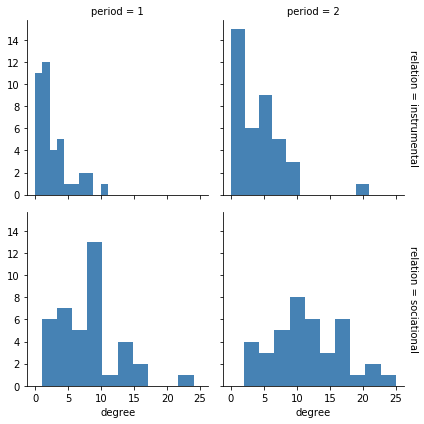

In [183]:
deg_hist=  sns.FacetGrid(df, row="relation", col="period", margin_titles=True)
#bins = np.linspace(0, 60, 13)
deg_hist.map(plt.hist, "degree", color="steelblue", bins=10);

## Clustering

In [185]:
#local clustering
clust = [local_clustering(gs[k]) for k in gs.keys()]
clust = [np.mean(x.a) for x in clust]
print('Local Clustering')
print(np.round(clust,3))

# global clustering
glob_clust = [global_clustering(gs[k]) for k in gs.keys()]
print('Global Clustering')
print(np.round(glob_clust,3))


Local Clustering
[0.163 0.323 0.458 0.498]
Global Clustering
[[0.194 0.026]
 [0.261 0.064]
 [0.385 0.034]
 [0.466 0.021]]


## Diameter

In [427]:
[pseudo_diameter(gs[k])[0] for k in gs.keys()]

[6.0, 5.0, 4.0, 3.0]

## Assortativity

In [525]:
print([assortativity(gs[k], "total") for k in gs.keys()])

print([scalar_assortativity(gs[k], "total") for k in gs.keys()])

[(-0.037658397287167585, 0.043331662786163794), (-0.019953051643192485, 0.03414735103978953), (-0.04904390934844193, 0.018027682628220187), (0.0024538012203860894, 0.01854325008362404)]
[(-0.1839762611275967, 0.27801586857855715), (-0.18306679863173073, 0.14384150336068346), (-0.18269136963096275, 0.21916798583072136), (-0.051098507986063885, 0.26274916671401227)]


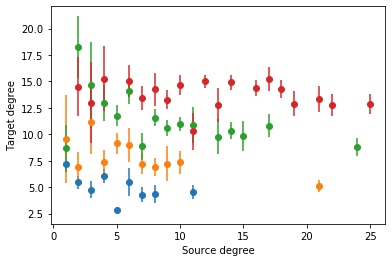

In [529]:
# Average neighbor-neighbor correlation
for k in gs.keys():
    h = avg_neighbor_corr(gs[k], "out", "out")
    #plt.clf()
    fig = plt.plot()
    plt.xlabel("Source degree")
    plt.ylabel("Target degree")
    plt.errorbar(h[2][:-1], h[0], yerr=h[1], fmt="o");

## SBM Inference

Select the best (nested) model among degree-corrected SBM and non degree-corrected SBM in terms of the smallest description length.

In [197]:
niter = 50
states = {}
for k in gs.keys():
    print(k)
    g = gs[k]
    state = minimize_nested_blockmodel_dl(g, deg_corr = True)
    for deg_corr in [True, False]:
        for i in range(niter):
            nstate = minimize_nested_blockmodel_dl(g, deg_corr=deg_corr)
            if nstate.entropy() < state.entropy():
                state = nstate    
    states[k] = state

ti1
ti2
ts1
ts2


Plot SBMs

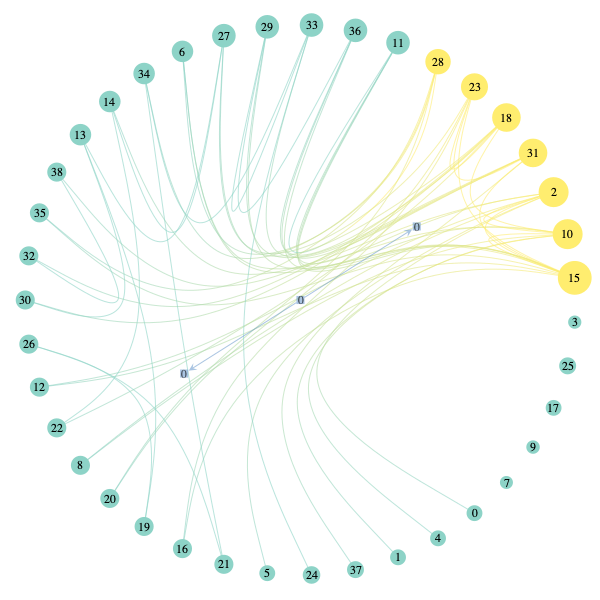

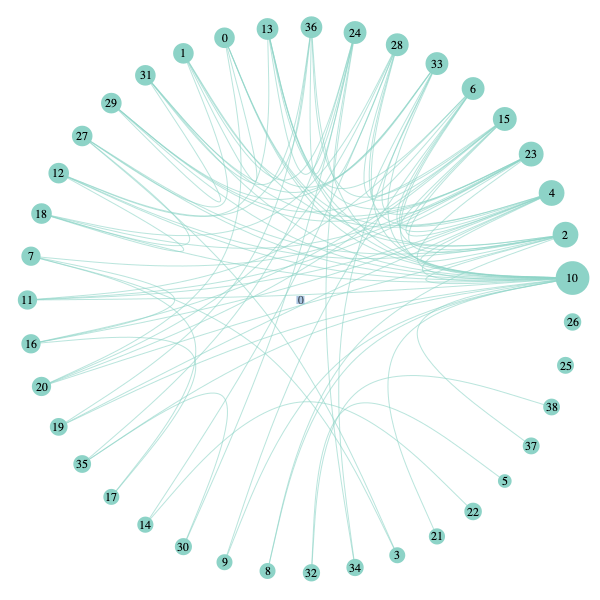

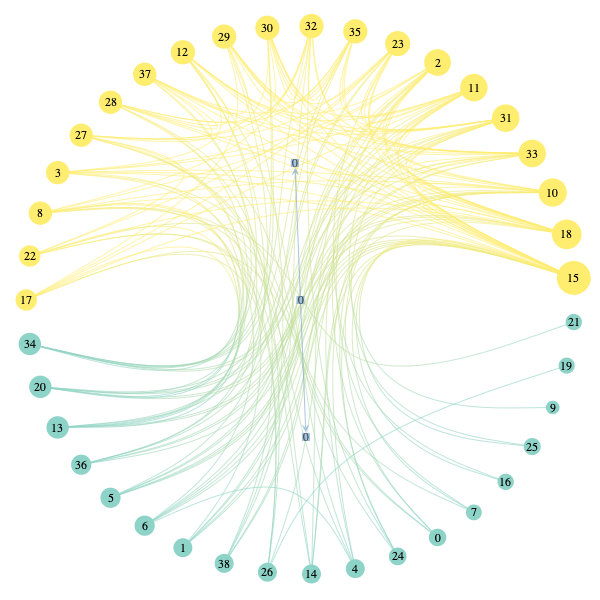

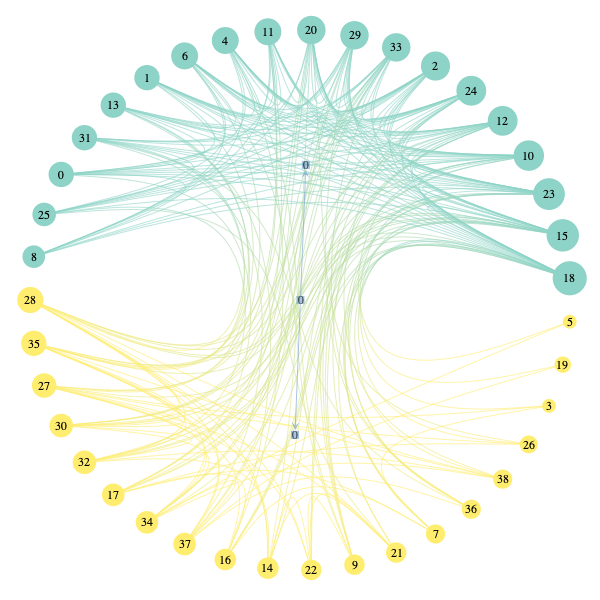

In [535]:
#pos = states[k].draw()
for k in gs.keys():    
    #states[k].draw(pos = states[k].g.own_property(pos), vertex_text = gs[k].vp['vstatus2'])
    states[k].draw(vertex_text = gs[k].vp['vlabel'])

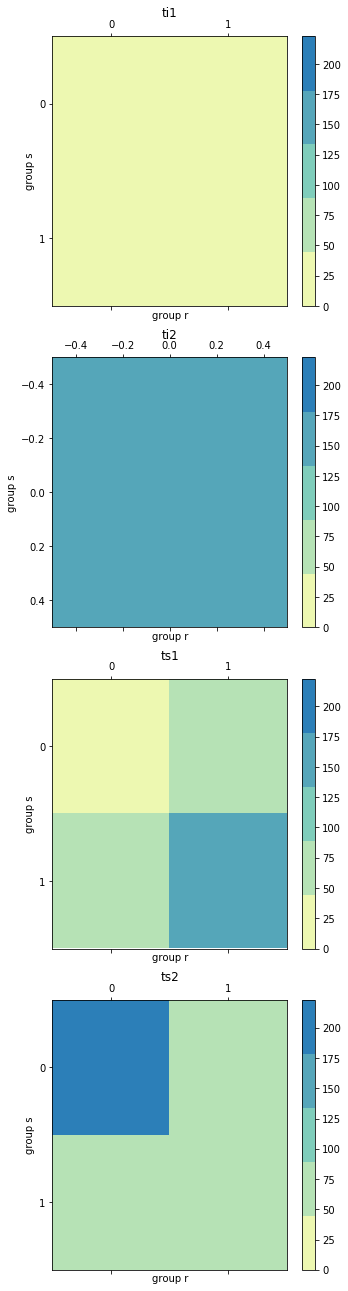

In [540]:
colors = 1/255*np.array([[237,248,177],[127,205,187],[44,127,184]])
colors = [tuple(i) for i in colors]          
n_bin = 5
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)

vmax = sorted([gs[k].num_edges() for k in gs.keys()])[-1]
#vmax = None

fig, ax = plt.subplots(4,1, figsize = (5,18))
l = 1
for i, k in enumerate(gs.keys()):
    he = states[k].get_bstack()
    he_adj = adjacency(he[l],weight=he[l].ep.count)
    img = ax[i].matshow(he_adj.todense(),aspect='auto',interpolation='none', 
                        vmin=0, vmax=vmax, cmap=cm)
    plt.colorbar(img, ax=ax[i])
    ax[i].set_title(k)
    ax[i].set_xlabel('group r')
    ax[i].set_ylabel('group s')
    
fig.tight_layout();

### Composition of groups

For the Sociational network, note the changes in the core, specially, in the job category 3.

In [433]:
print('job vs high status 1')
print(pd.crosstab(job_status,job_status_d[:,1]))
print('')

vstatus = {'high status 0': job_status_d[:,0], 'high status 1': job_status_d[:,1], 'job': job_status}
for j in vstatus.keys():
    for k in gs.keys():    
        print(k,'vs',j)
        print(pd.crosstab(states[k].get_bs()[0], vstatus[j]))
        print('')

print('ti1 vs ti2')        
print(pd.crosstab(states['ti1'].get_bs()[0],states['ti2'].get_bs()[0]))
print('')
print('ts1 vs ts2')        
print(pd.crosstab(states['ts1'].get_bs()[0],states['ts2'].get_bs()[0]))
print('')

job vs high status 1
col_0  0   1
row_0       
1      0   1
2      0   1
3      2  11
4      0   2
5      7   0
6      3   0
7      8   0
8      4   0

ti1 vs high status 0
col_0   0  1
row_0       
0      32  0
1       6  1

ti2 vs high status 0
col_0   0  1
row_0       
0      38  1

ts1 vs high status 0
col_0   0  1
row_0       
0      19  0
1      19  1

ts2 vs high status 0
col_0   0  1
row_0       
0      18  1
1      20  0

ti1 vs high status 1
col_0   0   1
row_0        
0      21  11
1       3   4

ti2 vs high status 1
col_0   0   1
row_0        
0      24  15

ts1 vs high status 1
col_0   0  1
row_0       
0      11  8
1      13  7

ts2 vs high status 1
col_0   0   1
row_0        
0       5  14
1      19   1

ti1 vs job
col_0  1  2   3  4  5  6  7  8
row_0                         
0      0  0  10  2  7  2  7  4
1      1  1   3  0  0  1  1  0

ti2 vs job
col_0  1  2   3  4  5  6  7  8
row_0                         
0      1  1  13  2  7  3  8  4

ts1 vs job
col_0  1  2  3  4  

## Alternative partitions

### Marginal probability on the number of groups

In [250]:
hs = {}
for k in gs.keys():
    g = gs[k]
    state = states[k].copy(sampling = True)
    # We will first equilibrate the Markov chain
    mcmc_equilibrate(state, wait=10000, mcmc_args=dict(niter=10))

    h = np.zeros(g.num_vertices() + 1)
    # Collect number of groups at the lowest level
    def collect_num_groups(s):
        #B = s.get_nonempty_B()
        B = s.get_bs()[0].max()
        h[B] += 1

    # Now we collect the marginals for exactly 100,000 sweeps, at
    # intervals of 10 sweeps:
    mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                        callback=collect_num_groups)
    hs[k] = h

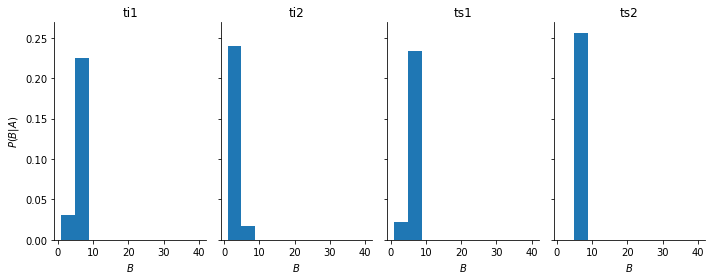

In [251]:
fig, ax = plt.subplots(1,4, figsize = (10,4), sharey = True)
for i, k in enumerate(gs.keys()):
    ax[i].hist(range(1,len(hs[k])+1),weights = hs[k], bins = 10, density = True)
    ax[i].set_title(k)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel(r'$B$')    
    ax[0].set_ylabel(r'$P(B|A)$')

fig.tight_layout()

## Alternative partitions

In [263]:
hs

{'ti1': array([   0.,  744.,   55.,  397.,  791., 5038., 2974.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 'ti2': array([5461.,  830., 2805.,  258.,  188.,  457.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 'ts1': array([   0.,  330.,  128.,  400.,  660., 1777., 6704.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 'ts2': array

In [ ]:
alt_states = {}
for k in gs.keys():
    alt_states[k] = minimize_nested_blockmodel_dl(gs[k], deg_corr = states[k].state_args['deg_corr'], B_min = hs[k].argmax()+1, B_max = hs[k].argmax()+1)     

In [868]:
gs[k].vp['vlabel']

<VertexPropertyMap object with value type 'int32_t', for Graph 0x158e01dd0, at 0x156123550>

Draw Nested SBM results. There vertex color corresponds to the group, the shape to the job status (circle: low-status, triangle: high-status), and the vertex label to the worker ID. Workers Lyahsi (node 10) and and Mubanga (node 33) played a special role in this case. 

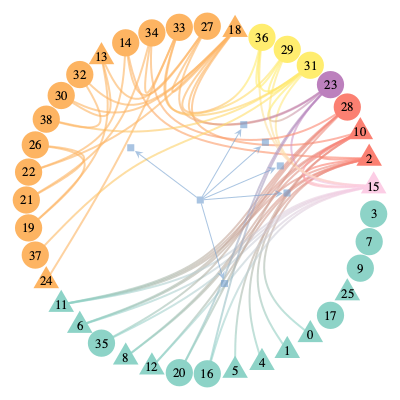

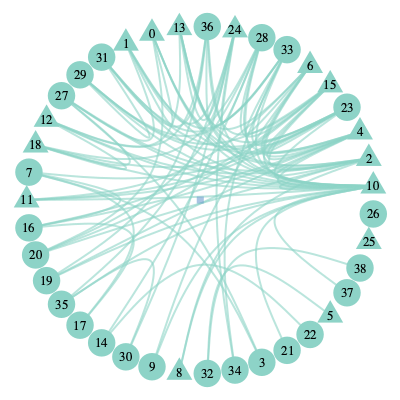

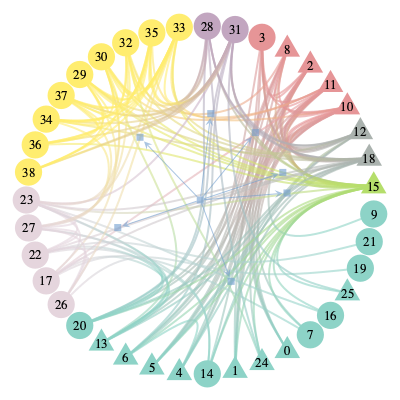

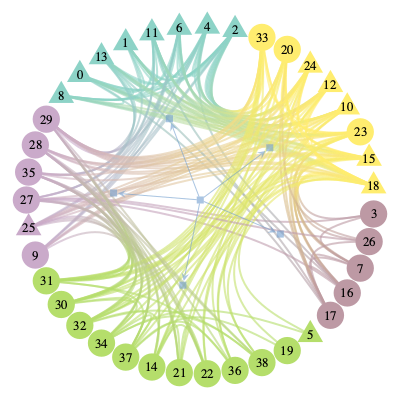

In [883]:
for k in gs.keys():
    alt_states[k].draw(vertex_text = gs[k].vp['vlabel'], vertex_font_size = 13,
                      vertex_shape = gs[k].vp['vstatus2'], vertex_size = 25,
                       edge_pen_width = 2, output_size = (400,400))

In [888]:
for k in gs.keys():
    print(alt_states[k].get_bs()[0])

[0 0 1 0 0 0 0 0 0 0 1 0 0 2 2 3 0 0 2 2 0 2 2 4 2 0 2 2 1 5 2 5 2 2 2 0 5
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[0 0 1 1 0 0 0 0 1 0 1 1 2 0 0 4 0 3 2 0 0 0 3 3 0 0 3 3 5 6 6 5 6 6 6 6 6
 6 6]
[0 0 0 1 0 2 0 1 0 3 4 0 4 0 2 4 1 1 4 2 4 2 2 4 4 3 1 3 3 3 2 2 2 4 2 3 2
 2 2]


In [342]:
sorted([gs[k].num_edges() for k in gs.keys()])

[57, 88, 158, 223]

Note the change in the structure of the networks

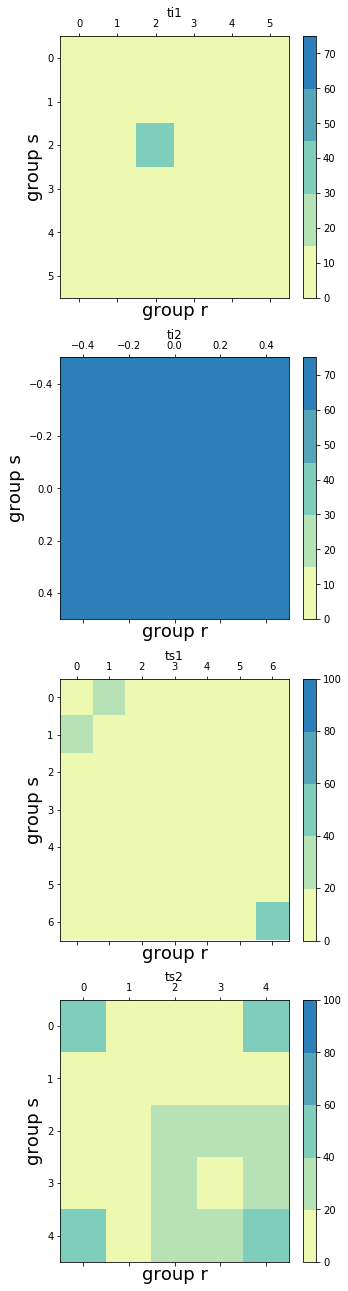

In [908]:
colors = 1/255*np.array([[237,248,177],[127,205,187],[44,127,184]])
colors = [tuple(i) for i in colors]          
n_bin = 5
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)

#vmax = sorted([gs[k].num_edges() for k in gs.keys()])[-2]

fig, ax = plt.subplots(4,1, figsize = (5,18))
l = 1
for i, k in enumerate(gs.keys()):
    if i < 2:
        vmax = 75
    else:
        vmax = 100
    he = alt_states[k].get_bstack()
    he_adj = adjacency(he[l],weight=he[l].ep.count)
    img = ax[i].matshow(he_adj.todense(),aspect='auto',interpolation='none', 
                        vmin=0, vmax=vmax, cmap=cm)
    plt.colorbar(img, ax=ax[i])
    ax[i].set_title(k)
    ax[i].set_xlabel('group r',fontsize=18)
    ax[i].set_ylabel('group s',fontsize=18)
    
fig.tight_layout();

## Composition of groups

In [425]:
print('job vs high status 1')
print(pd.crosstab(job_status,job_status_d[:,1]))
print('')

vstatus = {'high status 0': job_status_d[:,0], 'high status 1': job_status_d[:,1], 'job': job_status}
for j in vstatus.keys():
    for k in gs.keys():    
        print(k,'vs',j)
        print(pd.crosstab(alt_states[k].get_bs()[0], vstatus[j]))
        print('')

print('ti1 vs ti2')        
print(pd.crosstab(alt_states['ti1'].get_bs()[0],alt_states['ti2'].get_bs()[0]))
print('')
print('ts1 vs ts2')        
print(pd.crosstab(alt_states['ts1'].get_bs()[0],alt_states['ts2'].get_bs()[0]))
print('')

job vs high status 1
col_0  0   1
row_0       
1      0   1
2      0   1
3      2  11
4      0   2
5      7   0
6      3   0
7      8   0
8      4   0

ti1 vs high status 0
col_0   0  1
row_0       
0      16  0
1       3  0
2      14  1
3       1  0
4       1  0
5       3  0

ti2 vs high status 0
col_0   0  1
row_0       
0      38  1

ts1 vs high status 0
col_0   0  1
row_0       
0      15  0
1       5  0
2       1  1
3       5  0
4       1  0
5       2  0
6       9  0

ts2 vs high status 0
col_0   0  1
row_0       
0       8  0
1       5  0
2      12  0
3       6  0
4       7  1

ti1 vs high status 1
col_0   0  1
row_0       
0       7  9
1       1  2
2      12  3
3       0  1
4       1  0
5       3  0

ti2 vs high status 1
col_0   0   1
row_0        
0      24  15

ts1 vs high status 1
col_0  0  1
row_0      
0      7  8
1      1  4
2      0  2
3      5  0
4      0  1
5      2  0
6      9  0

ts2 vs high status 1
col_0   0  1
row_0       
0       0  8
1       5  0
2      11  1
3  

### Plot changes in the composition of groups by job status

In [757]:
groups_job = pd.DataFrame()
#groups_job['job'] = job_status
groups_job['job'] = job_status_d[:,1]
groups_job['ts1'] = alt_states['ts1'].get_bs()[0]
groups_job['ts2'] = alt_states['ts2'].get_bs()[0]

In [758]:
ct = pd.crosstab([groups_job['ts1'],groups_job['job']],
            [groups_job['ts2'],groups_job['job']])

In [760]:
# Identify positions different from 0
nz = np.where(ct.values > 0)
r = ct.index[nz[0]]
c = ct.columns[nz[1]]
v = ct.values[nz]

In [761]:
# Create graph
elist2 = [('ts1_'+str(r[i][0]),'ts2_'+str(c[i][0]),v[i]) for i in range(len(v))]         
bg2 = Graph(directed=False)
ew2 = bg2.new_ep("double")
vl2 = bg2.add_edge_list(elist2, hashed=True, string_vals=True, eprops=[ew2])

In [762]:
# Coordinates of nodes
xcoord = [int(x[2])+(int(x[2])==2)*3  for x in vl2.get_2d_array([0])[0]]
ycoord = [int(x[4]) for x in vl2.get_2d_array([0])[0]]

In [851]:
# Node labels
vlg = bg2.new_vp("string")
vlg.set_2d_array(np.array([x[4] for x in vl2.get_2d_array([0])[0]]))
# Edge color
#ejob = bg2.new_ep("string")
ejob = bg2.new_ep('int')
#job_pairs = np.array([str(r[i][1] > 3)+'-'+str(c[i][1] > 3) for i in range(len(v))])
job_pairs = np.array([str(r[i][1] == 1)+'-'+str(c[i][1] == 1) for i in range(len(v))])
ejobcolor = np.array([0]*len(job_pairs))
ejobcolor[job_pairs == 'True-True'] = 1
ejob.set_2d_array(ejobcolor)

# Node color
vcolor = bg2.new_vp("string", val="white")

In [852]:
# Node position
posbp = bg2.new_vp("vector<double>")
posbp.set_2d_array(np.array([xcoord,ycoord]))

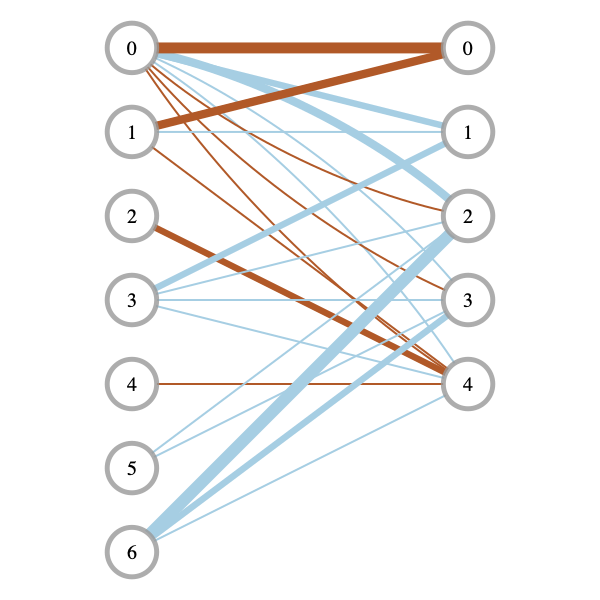

In [853]:
graph_draw(bg2, pos = posbp, vertex_text=vlg, vertex_font_size=20, 
             edge_pen_width=prop_to_size(ew2, 2, 12), edge_color = ejob,
              vertex_fill_color=vcolor, ecmap=matplotlib.cm.Paired);

## Changes of network descriptors on time

In [508]:
nd = pd.DataFrame()
nd['job_status'] = job_status
nd['high_status'] = [i[1] for i in job_status_d]

for k in gs.keys():
    nd[k+'_deg'] = gs[k].degree_property_map("out").a
    vb, eb = betweenness(gs[k],  norm = False)
    nd[k+'_bet'] = vb.a
    cl = closeness(gs[k], harmonic = True)
    nd[k+'_clo'] = cl.a
    

In [509]:
nd[nd.columns.to_list()[2:]].describe().round(2)

,ti1_deg,ti1_bet,ti1_clo,ti2_deg,ti2_bet,ti2_clo,ts1_deg,ts1_bet,ts1_clo,ts2_deg,ts2_bet,ts2_clo
count,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00
mean,2.92,27.26,0.32,4.51,18.26,0.39,8.10,19.82,0.57,11.44,14.67,0.64
std,2.54,37.55,0.14,3.82,37.77,0.16,4.83,29.21,0.09,5.51,18.57,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.34,2.00,0.00,0.46
25%,1.00,0.00,0.30,2.00,0.00,0.35,5.00,1.18,0.51,7.50,3.71,0.58
50%,2.00,11.34,0.34,4.00,2.70,0.44,8.00,11.33,0.58,11.00,7.44,0.64
75%,4.00,46.26,0.40,6.00,24.83,0.48,10.00,24.61,0.61,15.00,18.52,0.70
max,11.00,143.18,0.53,21.00,220.91,0.70,24.00,155.89,0.81,25.00,75.28,0.83


In [510]:
nd[nd.columns.to_list()[2:]].corr().round(3)

,ti1_deg,ti1_bet,ti1_clo,ti2_deg,ti2_bet,ti2_clo,ts1_deg,ts1_bet,ts1_clo,ts2_deg,ts2_bet,ts2_clo
ti1_deg,1.000,0.948,0.776,0.610,0.443,0.476,0.803,0.722,0.699,0.644,0.696,0.620
ti1_bet,0.948,1.000,0.612,0.587,0.454,0.453,0.774,0.713,0.655,0.611,0.723,0.583
ti1_clo,0.776,0.612,1.000,0.483,0.304,0.430,0.608,0.441,0.555,0.556,0.496,0.553
ti2_deg,0.610,0.587,0.483,1.000,0.856,0.731,0.438,0.265,0.415,0.632,0.536,0.610
ti2_bet,0.443,0.454,0.304,0.856,1.000,0.487,0.269,0.155,0.269,0.379,0.425,0.362
ti2_clo,0.476,0.453,0.430,0.731,0.487,1.000,0.354,0.180,0.306,0.580,0.444,0.570
ts1_deg,0.803,0.774,0.608,0.438,0.269,0.354,1.000,0.832,0.953,0.671,0.698,0.656
ts1_bet,0.722,0.713,0.441,0.265,0.155,0.180,0.832,1.000,0.718,0.524,0.644,0.503
ts1_clo,0.699,0.655,0.555,0.415,0.269,0.306,0.953,0.718,1.000,0.660,0.644,0.660
ts2_deg,0.644,0.611,0.556,0.632,0.379,0.580,0.671,0.524,0.660,1.000,0.838,0.993


In [511]:
print('Lyashi position:', job_status_d[:,0].argmax())

Lyashi position: 18


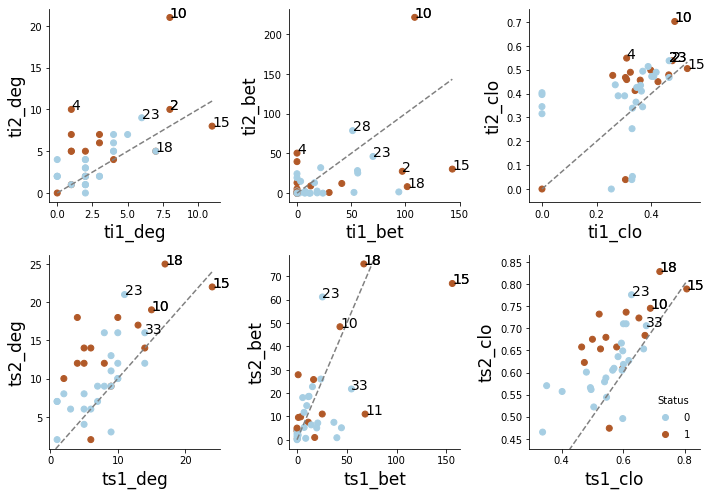

In [520]:
import matplotlib.lines as mlines


fig, ax = plt.subplots(2,3, figsize = (10,7))
for i,x in enumerate(['ti','ts']):
    for j, y in enumerate(['_deg','_bet','_clo']):
        scatter = ax[i,j].scatter(nd[x+'1'+y],nd[x+'2'+y], c = nd['high_status'], cmap = 'Paired')
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_xlabel(x+'1'+y, fontsize = 17)    
        ax[i,j].set_ylabel(x+'2'+y, fontsize = 17)
        
        tolabel = np.concatenate((np.argpartition(nd[x+'1'+y].values, -4)[-4:],
                                  np.argpartition(nd[x+'2'+y].values, -4)[-4:]))
        for z in tolabel:
            ax[i,j].annotate(str(z), (nd[x+'1'+y].iloc[z], nd[x+'2'+y].iloc[z]), fontsize = 14) 
        
        line = mlines.Line2D([0, nd[x+'1'+y].max()], [0, nd[x+'1'+y].max()], color='gray', ls = '--')
        ax[i,j].add_line(line)

ax[i,j].legend(*scatter.legend_elements(), loc="lower right", title="Status", frameon = False)
fig.tight_layout()